## Table of Contents

1. 探索的データ分析: EDA
2. よりたくさんの特徴量の作成
3. 性能を上げるための tips
2. LightGBM によるモデルの作成
3. 特徴重要度の可視化
4. Adversarial Validation

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, log_loss

In [2]:
input_dir = '/analysis/data/atmaCup7/inputs/'
output_dir = '/analysis/data/atmaCup7/outputs/'

train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

In [3]:
campaign_df = pd.read_csv(os.path.join(input_dir, 'campaign.csv'))

In [4]:
def preprocess(input_df):
    """
    下ごしらえ. 
    いろいろ merge する方法も共有されています 
    https://www.guruguru.science/competitions/12/discussions/b6b3dd96-1dc9-4e03-be99-6e4dcde75e61/
    数が多いので campaign だけ相手にすることにします
    """
    out_df = pd.merge(input_df, campaign_df[['id', 'mst_advertiser_order_id']], left_on='campaign_id', right_on='id', how='left')
    out_df = out_df.drop(columns=['id'])
    return out_df

In [5]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [6]:
whole_df = pd.concat([train_df, test_df], ignore_index=True)

## 探索的データ分析: EDA

EDA (探索的データ分析) とはデータをいろいろと探索的に調べて、データが何を示しているのかについての理解を深める作業のことです。分析作業に入る前にこのフェーズを行うことが多いです。

いろいろな観点で可視化等を行なうことが多いですが主に以下の2点にしたがってデータを見ていくことが多いです。

* カラムごとの性質を理解する (pandas-profiling / sweetviz)
    * [Pandas Profiling Report : train test | sinchir0 san](https://www.guruguru.science/competitions/12/discussions/7962772f-59df-4bd0-b7af-6b0c1576f4b6/)
    * [Sweetviz を用いた EDA | hmdhmd san](https://www.guruguru.science/competitions/12/discussions/c3259cad-7f44-4ec3-9c1f-8c477b8a121f/)
* train / test の分布がどう違うのかを理解する
    * [trainとtestの分布に注意してFirst EDA | hirayuki san](https://www.guruguru.science/competitions/12/discussions/f67b3413-2782-4125-8e10-f4b60c59caee/)

### train / test の分布の違いを理解する必要性について

train データは我々が(基本的に)すべての情報を与えられているデータです。一方でテストデータは予測すべき対象のデータで train とは異なっています。テストデータに対しての予測性能を上げるという観点では、この異なり方がどうなっているかを知ることがとても大事です。

真に我々が為し遂げたいことは「test データに対する予測を精度良く行なうことが可能な汎化したモデル」です。しかし学習自体は train で行いますから train / test がずれている要素を学習してしまうと train でせっかく見つけた特徴が test では現れないために予測性能が大幅に低下するということが発生します。

例えば train で target をよく説明できる変数があるのですが、これは test データだとすべて欠損しているとしましょう。今回のコンペティションでは特定のカラムは train にしか与えられていないですので、これらを使って学習したことに相当しますね。例えばそれが `"cv_at"` だったとします。

In [7]:
set(train_df.columns) - set(test_df.columns) - { 'target' }

{'click_or_view_at', 'cv_at', 'last_cv_interval', 'last_paid_interval'}

`"cv_at"` の値を元にモデルが予測を行っていれば、テストの時はその値が無いのですから正確な予測できないことは想像できるでしょう。

上記の例では全て欠損している極端な例を取り上げましたが、欠損はしていないけれど train の延長として考えることができない値が入っているカラムは要注意です。
例えば `os_version` で出現回数の割合を見てみましょう。

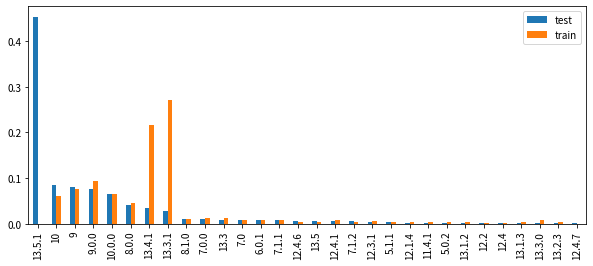

In [8]:
_df = pd.concat([
    test_df['os_version'].value_counts(normalize=True).rename('test'),
    train_df['os_version'].value_counts(normalize=True).rename('train'),
], axis=1).fillna(0)

_df.head(30).plot(kind='bar', figsize=(10, 4))

これを見ると, test では出現が多いけど train には全く無い version が含まれていることがわかります。もしこの os_vesion をカテゴリとみなし 学習している場合 `13.5.1` は null と変わりないと判断されてしまいます。

ですから例えば「バージョンが高いかどうか」という観点で数値化して特徴化する, などの方法を取ったほうが良い可能性があります。(たとえば 13.3.x -> 0 / 13.4.x -> 1 / 13.5.x -> 2 とみなすなど)

上記では `value_counts` を使って出現回数で比較しました。その他に venn 図を使って共通集合がどのぐらいあるかを可視化する方法もあります。

In [9]:
from matplotlib_venn import venn2

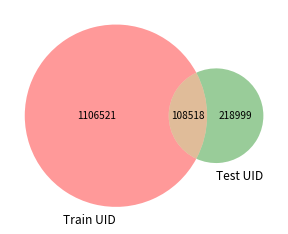

In [10]:
venn2(subsets=(set(train_df['uid'].unique()), set(test_df['uid'].unique())), set_labels=('Train UID', 'Test UID'))

### よりたくさんの特徴量の作成

本チュートリアルでは以下の3つの特徴量を作っていきます。

1. 連続変数特徴量
2. カテゴリ変数の特徴量化
    * CountEncoding
    * OneHotEncoding
3. 集約を使った特徴量
    * uid に関する集約特徴
    * より凝った集約特徴量

### 連続変数の特徴量

連続変数の場合そのままモデルが解釈出来るためコピーすればOKです。通常欠損値があると欠損のことを考慮する必要があります(モデルによっては欠損値が扱えない場合があるからです)。その場合平均値や中央値、更には別の方法で欠損を埋める必要がありますが lightGBM などの GBDT は欠損をそのまま自然に扱えるため、基本的に気にする必要はありません。

In [11]:
def create_continuous_features(input_df):
    use_columns = [
        # 連続変数
        'max_login_interval', 
        'frequency', 
        'login_frequency', 
        'last_login_interval',
        'from_click',
    ]
    return input_df[use_columns].copy()
    
def create_category_features(input_df):
    use_columns = [
        # category 系の id. label-encoding として使う
        'adnw_id',
        'adspot_id',
        'adspot_video_format_id',
        'game_feed_asset_type_id'
    ]
    return input_df[use_columns].copy()

## カテゴリ変数の変換

### CountEncoding

特定の値が何回出てくるか、に変換する方法です。

たとえば `[1, 1, 0, 2, 1]` という列があったとするとこれは `[3, 3, 1, 1, 3]` に変換されます。

このような変換をすることによって「そのレコードのカテゴリ値が珍しいかどうか」という情報をモデルが捉えられるようになります。  
(先の例だと `0` と `2` は同じ 1 になり、値自体は異なりますが珍しさでは同じ、という情報量になっているわけですね。)

In [12]:
c = 'category_id'

In [13]:
# 1. value count を使う方法
series = whole_df[c]
vc = series.value_counts(dropna=False)
pd.DataFrame(series.map(vc))

,category_id
0,38372
1,2205632
2,2205632
3,2205632
4,2205632
...,...
2387685,2205632
2387686,2205632
2387687,1387
2387688,2205632


In [14]:
# 2. groupby で作る方法もあるよ
_count = whole_df.groupby(c)['request_id'].count().rename('count')
_df = pd.merge(whole_df[c], _count, on=c, how='left')
_df = _df.drop(columns=[c])
_df

,count
0,38372
1,2205632
2,2205632
3,2205632
4,2205632
...,...
2387685,2205632
2387686,2205632
2387687,1387
2387688,2205632


In [15]:
def create_count_encoding_features(input_df):
    use_columns = [
        'category_id', 
        'adnw_id', 
        'adspot_id', 
        'app_id', 
        'advertiser_id',
        'uid', 
        'game_feed_id' # and more
    ]
    
    out_df = pd.DataFrame()
    
    for c in use_columns:
        series = whole_df[c]
        vc = series.value_counts(dropna=False)
        
        _df = pd.DataFrame(input_df[c].map(vc))
        out_df = pd.concat([out_df, _df], axis=1)
        
    out_df = out_df.add_prefix('CE_')
    return out_df

In [58]:
_df = create_count_encoding_features(train_df)
assert len(_df) == len(train_df)

### One-Hot Encoding

あるカテゴリ列のユニーク数だけの列を作って, 特定の行がその値に一致している時に 1 そうでない時に 0 になるような行列に変換する方法です。

例えば `[3, 1, 1, 2]` という列があったとするとこれは

```
[
    [0, 0, 1],
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0]
]
```

というように変換されます。

#### 注意

one-hot encoding はカテゴリのユニーク数分だけの列を作ります。そのためユニーク数が多い列 (カーディナリティ(濃度)が高いといったりもします) に対して適用すると超巨大なスパース行列ができてしまいます。こうなるとメモリも大量に必要としますし LightGBM のような木構造には不向きですから使わないようにしてください。そのような場合には LabelEncoding 或いは TargetEncoding など変換後に列が増えない変換を検討してみてください。

In [17]:
c = 'auction_type_id'
vc = whole_df[c].value_counts()

In [18]:
# カーディナリティチェック. 3 ならいけるかな
len(vc)

3

In [19]:
series = train_df[c]
cat = pd.Categorical(series, categories=whole_df[c].dropna().unique())

In [20]:
cat

[1.0, 2.0, 1.0, 1.0, 4.0, ..., 2.0, 1.0, 2.0, 1.0, 1.0]
Length: 1997595
Categories (3, float64): [1.0, 2.0, 4.0]

In [21]:
# pd.get_dummies で one-hot の形式に変換できます
pd.get_dummies(cat)

,1.0,2.0,4.0
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
1997590,0,1,0
1997591,1,0,0
1997592,0,1,0
1997593,1,0,0


In [22]:
def create_onehot_encoding_features(input_df):
    use_columns = [
        # カーディナリティが比較的低めなものに絞っています
        'auction_type_id', 'header_bidding', 'is_interstitial', 'user_type_id' # and more
    ]
    
    out_df = pd.DataFrame()
    for c in use_columns:
        series = input_df[c]
        cat = pd.Categorical(series, categories=whole_df[c].dropna().unique())
        _df = pd.get_dummies(cat)
        _df.columns = _df.columns.tolist()
        _df = _df.add_prefix(c + '=')
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df.add_prefix('OH_')

In [23]:
create_onehot_encoding_features(train_df)

,OH_auction_type_id=1.0,OH_auction_type_id=2.0,OH_auction_type_id=4.0,OH_header_bidding=0.0,OH_header_bidding=1.0,OH_is_interstitial=1.0,OH_is_interstitial=0.0,OH_user_type_id=1,OH_user_type_id=2,OH_user_type_id=4,OH_user_type_id=3
0,1,0,0,1,0,1,0,1,0,0,0
1,0,1,0,1,0,1,0,0,1,0,0
2,1,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1997590,0,1,0,1,0,1,0,0,1,0,0
1997591,1,0,0,1,0,1,0,0,1,0,0
1997592,0,1,0,0,0,0,1,0,1,0,0
1997593,1,0,0,0,0,0,1,1,0,0,0


#### note: カテゴリ変数の取り扱い方についての参考文献

上記で紹介した方法以外にもいくつかの encoding の方法がありそれぞれ特性があります。以下に参考となる文献を貼っています。

* 日本人 GrandMaster の jack さんの kaggle-days-tokyo での発表 [How to encode categorical features for GBDT](https://speakerdeck.com/rsakata/how-to-encode-categorical-features-for-gbdt?slide=5) では各種の encoding の方法がパフォーマンスにどう影響するのかについての議論がされています。
* wantedly の Goda さんの発表 [Target Encoding はなぜ有効なのか](https://speakerdeck.com/hakubishin3/target-encoding-hanazeyou-xiao-nafalseka) では target encoding が他の encoding 方法にくらべ優れている理由についての議論がされています。

### 集約を使った特徴量

最後に column に対しての集約を使った特徴量を作ってみましょう。先ほど `CountEncoding` を紹介しました。これは集約したときに値ごとに全レコードで何回表れるかに変換する作業です。これと同様にして「集約した時に 〜 である数」を作れば、同じように特徴にすることができます。

ポピュラーなのは連続変数の値の平均値とか最大、最小値を使うものですね。

In [24]:
# agg を使うことで複数の集約を一気に実行することができます
# https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.SeriesGroupBy.aggregate.html

whole_df.groupby('uid')['last_login_interval'].agg(['mean', 'std'])

,mean,std
uid,,
00000875c54c0f8fcb76,14299.0,NaN
00001f0fd3c477ade4a0,15678.0,NaN
0000227f0ef616888399,27142.0,NaN
000026250cb6b0f3ec3c,14613.0,NaN
00002a63e4e60345ad71,4765.0,NaN
...,...,...
ffffa232fd448db3eaa8,4011.0,NaN
ffffb0e8ed58603e3d06,11869.0,NaN
ffffb7732656f64a0091,52957.0,NaN


あとよくやるのは「集約した時にユニークな値がなんこあるか」というやつですね。例えば下の例だと「このユーザーはどれだけの種類の配信元を見ている人か」という情報になっています。(これが多い人は、多分いろんなゲームとかする人なんだろうな、と推察されますね)

In [25]:
whole_df.groupby('uid')['advertiser_id'].nunique()

uid
00000875c54c0f8fcb76    1
00001f0fd3c477ade4a0    1
0000227f0ef616888399    1
000026250cb6b0f3ec3c    1
00002a63e4e60345ad71    1
                       ..
ffffa232fd448db3eaa8    1
ffffb0e8ed58603e3d06    1
ffffb7732656f64a0091    1
ffffbf024fcec612c783    1
ffffd8a0f740476ae95d    1
Name: advertiser_id, Length: 1434038, dtype: int64

上記で groupby した結果の data-frame (or Series) は index に uid を持っているので train (or test) に対して uid を key として left join することで特徴量列として追加することができます。以下は上記で紹介した集約を特徴量にする関数です。

In [26]:
def _run_aggregation(input_df: pd.DataFrame, agg_column='uid') -> pd.DataFrame:
    """uid に関する aggregation 特徴量"""
    
    # note: 
    #   この集約はとても重たい処理になりがちです(特にnunique). しかも train / test で共通の処理で毎回 call されるため無駄です
    #   例えば別のコードで `_agg_df` だけ作ってローカルに保存するコードをかいておいて
    #   実際に特徴量を作成するときにはそちらを読み込む用にするなどすると高速化になります
    _agg_df = pd.concat([
        whole_df.groupby(agg_column)['last_login_interval'].agg(['mean', 'min', 'max']).add_prefix('last_login_interval_'),
        whole_df.groupby(agg_column)['advertiser_id'].nunique()
    ], axis=1)
    
    out_df = pd.merge(input_df[agg_column], _agg_df, on=agg_column, how='left')
    out_df = out_df.drop(columns=agg_column).add_suffix('_by_{}'.format(agg_column))
    return out_df

In [27]:
# 上記 Note を元に, オブジェクト指向 like に書き直す

class MultipleAggFeature:
    def __init__(self, agg_column: str):
        """
        Args:
            agg_column: str
                集約の key になる column 名.
        """
        self._agg_df = None
        self.agg_column = agg_column
        
        if agg_column not in whole_df.columns:
            raise ValueError('invalid `"agg_column"`')
        
    def create_agg_df(self):
        agg_column = self.agg_column
        self._agg_df = pd.concat([
            whole_df.groupby(agg_column)['last_login_interval'].agg(['mean', 'min', 'max']).add_prefix('last_login_interval_'),
            whole_df.groupby(agg_column)['advertiser_id'].nunique()
        ], axis=1)
        return self._agg_df
    
    @property
    def __name__(self):
        return 'multiple_agg_by_{}'.format(self.agg_column)
        
    @property
    def already_aggregated(self):
        return self._agg_df is not None
        
    def __call__(self, input_df: pd.DataFrame) -> pd.DataFrame:
        if not self.already_aggregated:
            print('start create agg features...')
            self._agg_df = self.create_agg_df()
            
        _agg_df = self._agg_df
        agg_column = self.agg_column
        
        # 単に集約して suffix つけるだけなので関数化して外に出してもいいかもしれません
        out_df = pd.merge(input_df[agg_column], _agg_df, on=agg_column, how='left')
        out_df = out_df.drop(columns=agg_column).add_suffix('_by_{}'.format(agg_column))
        return out_df

### ちょっと凝った集約特徴

上記は集約対象がすでに train (or test) に存在するカラムでした。
いま存在するカラムでやってもちょっとおもしろくないので時系列情報でちょっと凝ったものを作ってみます。

「ユーザーごとに見た時に impression がどういう時刻に起こりやすいか」を特徴にしてみます。impression のカラムを時系列として扱いたいので `to_datetime` を使って datetime に変換します。こうすることで `imp_at` の Series に対して `dt` から hour や days などカラムを時刻としてみなした値にアクセスできます.

In [28]:
from datetime import timedelta

imp_at = pd.to_datetime(whole_df['imp_at']) + timedelta(hours=9) # utc -> asia/tokyo
out_df = pd.DataFrame()
out_df['hours'] = imp_at.dt.hour
out_df['dayofweek'] = imp_at.dt.dayofweek
out_df['hour_zone'] = pd.cut(out_df['hours'].values, bins=[-np.inf, 6, 12, 18, np.inf]).codes
out_df['uid'] = whole_df['uid']

In [29]:
out_df.head()

,hours,dayofweek,hour_zone,uid
0,9,1,1,30cfce348022c3812b3a
1,9,1,1,4c28854cab6a85c37dab
2,9,1,1,b35f0cd7210c4273489c
3,9,1,1,57dc1bf69be06dac416c
4,9,1,1,7ca7b54b97093b084027


これからユーザーごとに集計して何時に impression があったかのデータに変換します。2つのカラムの共起で集約するような場合には pivot table が便利です.

In [30]:
_piv_df = pd.pivot_table(out_df, index='uid', columns='dayofweek', values='hours', aggfunc='count')
_piv_df.head()

dayofweek,0,1,2,3,4,5,6
uid,,,,,,,
00000875c54c0f8fcb76,NaN,NaN,NaN,NaN,NaN,NaN,1.0
00001f0fd3c477ade4a0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
0000227f0ef616888399,NaN,NaN,NaN,NaN,NaN,NaN,1.0
000026250cb6b0f3ec3c,NaN,NaN,1.0,NaN,NaN,NaN,NaN
00002a63e4e60345ad71,NaN,NaN,NaN,NaN,NaN,NaN,1.0


カウントの大小等よりは、何時にアクセスしやすいかという傾向を特徴化したいので行方向に正規化します

In [31]:
_piv_df = _piv_df.fillna(0)
_piv_df.div(_piv_df.sum(axis=1), axis=0)

dayofweek,0,1,2,3,4,5,6
uid,,,,,,,
00000875c54c0f8fcb76,0.0,0.0,0.0,0.0,0.0,0.0,1.0
00001f0fd3c477ade4a0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0000227f0ef616888399,0.0,0.0,0.0,0.0,0.0,0.0,1.0
000026250cb6b0f3ec3c,0.0,0.0,1.0,0.0,0.0,0.0,0.0
00002a63e4e60345ad71,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
ffffa232fd448db3eaa8,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ffffb0e8ed58603e3d06,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ffffb7732656f64a0091,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
def _create_whole_imp_at_feature() -> pd.DataFrame:
    """impression が起こった時刻が dayofweek / hour_zone の意味でどれだけ偏っているか集計した data-frame を作成する"""
    
    imp_at = pd.to_datetime(whole_df['imp_at']) + timedelta(hours=9) # utc -> asia/tokyo
    out_df = pd.DataFrame()
    out_df['hours'] = imp_at.dt.hour
    out_df['dayofweek'] = imp_at.dt.dayofweek
    out_df['hour_zone'] = pd.cut(out_df['hours'].values, bins=[-np.inf, 6, 12, 18, np.inf]).codes

    def _create_pivot(input_df, c, column='dayofweek', values='hours'):
        _df = pd.pivot_table(data=input_df, index=[c], columns=[column], values=values, aggfunc='count')
        _df = _df.fillna(0)
        _df.columns = [column + '=' + str(x) for x in _df.columns]
        
        # index ごとに正規化して割合にする
        _df = _df.div(_df.sum(axis=1), axis=0)
        return pd.merge(input_df[c], _df, on=c, how='left').drop(columns=[c]).add_prefix(c + '_')

    # uid での集約
    for c in ['uid']:
        _df = out_df.copy()
        _df[c] = whole_df[c]
        _feat = pd.concat([
            _create_pivot(_df, c),
            _create_pivot(_df, c, column='hour_zone', values='dayofweek')  
        ], axis=1)
        out_df = pd.concat([out_df, _feat], axis=1)
        
    out_df['request_id'] = whole_df['request_id']
    return out_df

In [33]:
datetime_whole_df = _create_whole_imp_at_feature()

上記で作った uid ごとの集約データを train / test の data-frame と left-join すれば特徴量となります。

In [34]:
def create_imp_at_agg_features(input_df):
    return pd.merge(input_df['request_id'], 
                    datetime_whole_df, 
                    on='request_id', 
                    how='left').drop(columns=['request_id'])

### Tips

#### [note1]: 集約対象の値の作り方

勾配ブースティングは特徴量ごとの相互作用に関しては直接的に捉えることが不可能ですので、足し算引き算や割り算をして割合として捉えたり、掛け算をして合計の量にするといった操作でより良いモデルが作成できる場合があります.

闇雲に四則演算等を行なうことでも作れますが、このデータがどのように発生したかの物理的な意味を考えつつ値を作ると効果的な特徴を作ることができます。この時引き算・足し算は同じ次元の値に対して行なうと良い場合が多い印象です。例えば...

* `first_login_interval` と `last_login_interval` の引き算 (interval という意味で次元が同じ)
* `cv_at` と `imp_at` の引き算 (datetime どうしで次元が同じ)
* などなど…

上記の演算方法で何が良いのか?については、結局のところデータがどいういうものかに依存します。discussion に上がっているデータおよび target flag の生成のされ方についてじっくり読んでみて、アイディアをねるのも良いと思います。

* [Target Flagの付き方について | ykaneko san](https://www.guruguru.science/competitions/12/discussions/222561fa-8148-446f-b312-6cb1184eaad0/)
* [データの細かい説明 | ykaneko san](https://www.guruguru.science/competitions/12/discussions/51745f12-b591-44f1-b306-bd5eb14554d8/)
    * コメントで質問されている内容にもヒントがあるかもしれません。
* [GameFeed, GameFeedTemplateとはなにか? | ykaneko san](https://www.guruguru.science/competitions/12/discussions/84636534-4885-41e4-b929-91969e535645/)
    * 広告の出方について説明されています。実際にどうやって広告が配信されるかを考えてみるのは有効だと思います。
* [Welcome to atmaCup#7](https://www.guruguru.science/competitions/12/discussions/8646ed76-eb91-4084-9eea-8b30a2ae0932/)
    * いくつかデータに関する質問に答えてます

#### [note2]: trainにしか存在しない特徴量について

train にしかない特徴量は test にないから入っていても意味がないと思っていませんか? これらのカラムは確かに直接は使えませんが、集約を介することで test でも利用可能な情報にすることができます。例えば `click_or_viewed_at` の `hour` を取り出して `uid` で集約してみると?

#### [note3]: コードのチェック

今回の関数は簡単ですがもう少し込み入ったことをする場合、自分が書いたコードがあっているのか怪しくなってくることがあります。その場合以下のことをテストしておくと単純なミスなどによるエラーを防ぐことができます。

* 入力に対して、出力の shape は正しいか (行の数と特徴量の数は一致しているか)
* 再現性があるか (同じ入力に対して同じ出力を得ることが出来るか)

特に one-hot-encoding などカテゴリ変数の変換の際に train / test で重複しないカテゴリがあって train / test でカラムの数が違うなどよくあるミスなので注意してください。

In [35]:
_df = create_imp_at_agg_features(train_df)
assert len(train_df) == len(_df) # ながさチェック
assert _df.equals(create_imp_at_agg_features(train_df)) # 再現性チェック

In [36]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [37]:
from tqdm import tqdm

processors = [
    # この2つは最初の Tutorial と同じ
    create_continuous_features,
    create_category_features,
    
    # 追加したもの.
    create_count_encoding_features,
    create_onehot_encoding_features,
    create_imp_at_agg_features,
    MultipleAggFeature('uid')
]

def to_feature(input_df):
    out_df = pd.DataFrame()
    
    for func in processors:
        with timer(prefix='-- ' + func.__name__ + ' --'):
            _df = func(input_df)        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [38]:
with timer(prefix='create train feature '):
    train_feat_df = to_feature(train_df)

with timer(prefix='create test feature '):
    test_feat_df = to_feature(test_df)

-- create_continuous_features --0.054[s]
-- create_category_features --0.051[s]
-- create_count_encoding_features --4.566[s]
-- create_onehot_encoding_features --0.357[s]
-- create_imp_at_agg_features --2.534[s]
start create agg features...
-- multiple_agg_by_uid --10.224[s]
create train feature 19.370[s]
-- create_continuous_features --0.009[s]
-- create_category_features --0.007[s]
-- create_count_encoding_features --3.201[s]
-- create_onehot_encoding_features --0.169[s]
-- create_imp_at_agg_features --1.785[s]
-- multiple_agg_by_uid --0.866[s]
create test feature 6.289[s]


In [39]:
import lightgbm as lgbm

from sklearn.metrics import average_precision_score
import lightgbm as lgbm

def pr_auc(y_true, y_pred):
    """lightGBM の round ごとに PR-AUC を計算する用"""
    score = average_precision_score(y_true, y_pred)
    return "pr_auc", score, True

def fit_lgbm(X, y, cv, params: dict=None, verbose=100):

    # パラメータがないときはからの dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose, 
                    eval_metric=pr_auc,
                    verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} PR-AUC: {average_precision_score(y_valid, pred_i):.4f}')

    score = average_precision_score(y, oof_pred)
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

In [40]:
params = {
    'objective': 'binary',
    'learning_rate': .1,
    'reg_lambda': .1,
    'max_depth': 5,
    'n_estimators': 10000,
    'colsample_bytree': .5
}

y = train_df['target'].values

In [41]:
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [42]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.115868	valid_0's pr_auc: 0.209077
[200]	valid_0's binary_logloss: 0.113569	valid_0's pr_auc: 0.221389
[300]	valid_0's binary_logloss: 0.112462	valid_0's pr_auc: 0.227904
[400]	valid_0's binary_logloss: 0.111833	valid_0's pr_auc: 0.232096
[500]	valid_0's binary_logloss: 0.111454	valid_0's pr_auc: 0.234168
[600]	valid_0's binary_logloss: 0.111118	valid_0's pr_auc: 0.236785
[700]	valid_0's binary_logloss: 0.110841	valid_0's pr_auc: 0.239018
[800]	valid_0's binary_logloss: 0.110599	valid_0's pr_auc: 0.240797
[900]	valid_0's binary_logloss: 0.110457	valid_0's pr_auc: 0.241842
[1000]	valid_0's binary_logloss: 0.11032	valid_0's pr_auc: 0.242457
[1100]	valid_0's binary_logloss: 0.110246	valid_0's pr_auc: 0.242775
[1200]	valid_0's binary_logloss: 0.110191	valid_0's pr_auc: 0.243078
Early stopping, best iteration is:
[1177]	valid_0's binary_logloss: 0.110188	valid_0's pr_auc: 0.243173
fit fold=1 213.5

### 特徴重要度の確認

LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。

In [60]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .mean()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(7, len(order) * .2))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax, palette='viridis')
    ax.grid()
    fig.tight_layout()
    return fig, ax

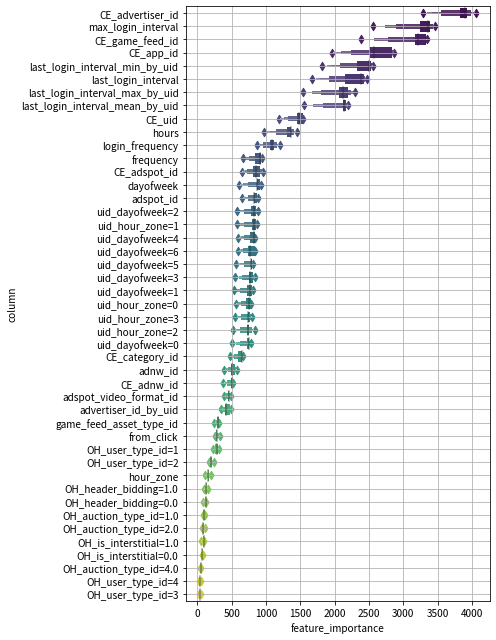

In [61]:
fig, ax = visualize_importance(models, train_feat_df)

feature importance からわかることとしては

* `advertiser_id` に関する CountEncoding が大事そう → Count以外の集約も大事かもしれません。
* `login_interval` が重要になっていて uid での集約結果も大事になっています → それ以外のカラムで集約した場合も大事かもしれません。

In [45]:
pred = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])
pred = np.mean(pred, axis=0)

sub_df = pd.DataFrame({ 'target': pred })
sub_df.to_csv(os.path.join(output_dir, 'submission.csv'), index=False)

## Adversarial Validation

train と test の分布が離れている度合いを測る方法の一つとして Adversarial Validation と呼ばれる方法があります。これは train か test かを分類する問題を機械学習で解くことによって train / test が分割しやすいかどうか = 分布がずれている特徴があるかどうかを判定する方法です。

以下では今回の特徴量を使って train の時 1 になるような binary classification を実行して, 分布のズレを確かめます。

In [46]:
whole_feat_df = pd.concat([train_feat_df, test_feat_df], ignore_index=True)
adv_target_labl = [True] * len(train_df) + [False] * len(test_df)
adv_target_labl = np.array(adv_target_labl)

In [47]:
adv_params = {
    'n_estimators': 100
}

adv_cv = StratifiedKFold(shuffle=True, random_state=71).split(whole_feat_df, adv_target_labl)
adv_oof, adv_models = fit_lgbm(whole_feat_df.values, 
                               y=adv_target_labl, 
                               cv=adv_cv, 
                               params=adv_params)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.238598	valid_0's pr_auc: 0.985232
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.238598	valid_0's pr_auc: 0.985232
fit fold=1 23.088[s]
Fold 0 PR-AUC: 0.9852
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.235183	valid_0's pr_auc: 0.986109
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.235183	valid_0's pr_auc: 0.986109
fit fold=2 23.216[s]
Fold 1 PR-AUC: 0.9861
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.234919	valid_0's pr_auc: 0.986007
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.234919	valid_0's pr_auc: 0.986007
fit fold=3 23.554[s]
Fold 2 PR-AUC: 0.9860
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.23636	valid_0's pr_auc: 0.985817
Did 

In [48]:
train_feat_df.columns.tolist()

['max_login_interval',
 'frequency',
 'login_frequency',
 'last_login_interval',
 'from_click',
 'adnw_id',
 'adspot_id',
 'adspot_video_format_id',
 'game_feed_asset_type_id',
 'CE_category_id',
 'CE_adnw_id',
 'CE_adspot_id',
 'CE_app_id',
 'CE_advertiser_id',
 'CE_uid',
 'CE_game_feed_id',
 'OH_auction_type_id=1.0',
 'OH_auction_type_id=2.0',
 'OH_auction_type_id=4.0',
 'OH_header_bidding=0.0',
 'OH_header_bidding=1.0',
 'OH_is_interstitial=1.0',
 'OH_is_interstitial=0.0',
 'OH_user_type_id=1',
 'OH_user_type_id=2',
 'OH_user_type_id=4',
 'OH_user_type_id=3',
 'hours',
 'dayofweek',
 'hour_zone',
 'uid_dayofweek=0',
 'uid_dayofweek=1',
 'uid_dayofweek=2',
 'uid_dayofweek=3',
 'uid_dayofweek=4',
 'uid_dayofweek=5',
 'uid_dayofweek=6',
 'uid_hour_zone=0',
 'uid_hour_zone=1',
 'uid_hour_zone=2',
 'uid_hour_zone=3',
 'last_login_interval_mean_by_uid',
 'last_login_interval_min_by_uid',
 'last_login_interval_max_by_uid',
 'advertiser_id_by_uid']

In [49]:
roc_auc_score(adv_target_labl, adv_oof)

0.9345296830802942

(<Figure size 504x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe64f70aa90>)

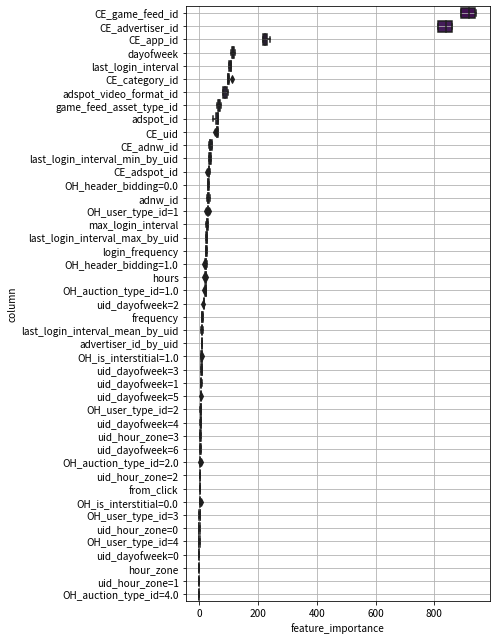

In [50]:
visualize_importance(adv_models, whole_feat_df)

### ここからわかること

* CountEncoding 系
    * train / test の長さがずれていて, test にしか存在しない id は必然的に出現回数が減ってしまうのが理由の一つとして考えられます。
* last / first login interval
    * ユーザーごとのログインの仕方が train / test で違うっぽい? (そもそも user がかぶっていないのが原因?)
* 集約系の特徴量
    * groupby する key のうち train (or test) にしか存在しないものが存在しているのも理由の一つ?
* [Adversarial feature selection | hirayuki san](https://www.guruguru.science/competitions/12/discussions/67848767-5a14-4255-ad19-69addef6582e/) でもこの notebook と同様に adversarial validation を行っています。こちらも参考にしてみると良いかもしれません。

## Future Work

* 特徴量をもっと増やす
    * テーブルデータの分析で、もっとも大事になるのは特徴量作成の部分です。今回上げたもの以外の特徴量を試してみましょう。
* LightGBM 以外のモデルを試す (XGBoost / Catboost / RandomForest / Linear Model)
    * 特徴量ほど差は出ませんが LightGBM 以外のモデルを使うと性能が向上する可能性があります。
    * モデルを変えただけで性能が上がらなくても単に平均を取ったりアンサンブルすることで性能向上する場合もあります。
* パラメータチューニング
    * Optuna を使ってパラメータチューニングなど考えられます、が基本的に特徴量の重要さに比べるとこちらは誤差のようなものなので、データをしっかりと見て特徴を考えるほうが優先度が高いです。

## Appendix

たとえば: `RandomForest`

In [51]:
from sklearn.ensemble import RandomForestClassifier

def fit_model(X, y, cv, model_class, params: dict=None, verbose=100):

    # パラメータがないときはからの dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = model_class(**params)
        clf.fit(x_train, y_train)
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} PR-AUC: {average_precision_score(y_valid, pred_i):.4f}')

    score = average_precision_score(y, oof_pred)
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

In [52]:
X_train_filled = train_feat_df.fillna(train_feat_df.median()).values

In [53]:
params = {
    'n_jobs': -1,
    'verbose': 1,
    'random_state': 71
}

oof_rf, models_rf = fit_model(X_train_filled, y, cv, RandomForestClassifier, params=params)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.7s finished


Fold 0 PR-AUC: 0.1954


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.7s finished


Fold 1 PR-AUC: 0.1955


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.7s finished


Fold 2 PR-AUC: 0.1953


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.7s finished


Fold 3 PR-AUC: 0.1942


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.7s finished


Fold 4 PR-AUC: 0.1950
FINISHED \ whole score: 0.1950


In [54]:
oof_df = pd.DataFrame({
    'lgbm': oof,
    'rf': oof_rf
})

In [55]:
oof_df.corr()

,lgbm,rf
lgbm,1.000000,0.792704
rf,0.792704,1.000000


In [56]:
average_precision_score(y, oof_df.mean(axis=1).values)

0.2378707571865364